<a href="https://colab.research.google.com/github/sreebalajisree/Fake_News_Detection/blob/main/Fake_News_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [147]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Sk-Learn libraries
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Glob for text pre-processing
import glob

#Tensorflow libraries for model building, validation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional, Input, Activation
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping

#Load the dataset

In [148]:
fake_train = pd.read_excel("/content/sample_data/data/Constraint_English_Train.xlsx")
fake_valid = pd.read_excel("/content/sample_data/data/Constraint_English_Val.xlsx")
fake_test = pd.read_excel("/content/sample_data/data/Constraint_English_Test_without_labels.xlsx")
fake_external1 = pd.read_excel("/content/sample_data/data/external_1.xlsx")
fake_external2 = pd.read_excel("/content/sample_data/data/external_2.xlsx")
df_pseudo = pd.read_csv("/content/sample_data/data/pseudo_submission.csv")

#Helper Function to plot the graph

In [149]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Read the train-set top 5 values

In [150]:
fake_train.head()

,id,tweet,label
0,1.0,The CDC currently reports 99031 deaths. In gen...,real
1,2.0,States reported 1121 deaths a small rise from ...,real
2,3.0,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4.0,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5.0,Populous states can generate large case counts...,real


Read the test-set top 5 values

In [151]:
fake_test.head()

,id,tweet
0,1.0,Our daily update is published. States reported...
1,2.0,Alfalfa is the only cure for COVID-19.
2,3.0,President Trump Asked What He Would Do If He W...
3,4.0,States reported 630 deaths. We are still seein...
4,5.0,This is the sixth time a global health emergen...


Read the validation-set top 5 values

In [152]:
fake_valid.head()

,id,tweet,label
0,1.0,Chinese converting to Islam after realising th...,fake
1,2.0,11 out of 13 people (from the Diamond Princess...,fake
2,3.0,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4.0,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5.0,6/10 Sky's @EdConwaySky explains the latest #C...,real


#Data preprocessing

In [153]:
#Data preprocessing

def data_process(data):
  for i, label in enumerate(data['label']):
    if(data['label'][i] == "real"):
      data['label'][i] = 1
    else:
      data['label'][i] = 0

In [154]:
fake_train1 = pd.concat([fake_train['tweet'], fake_train['label']], axis=1)
fake_valid1 = pd.concat([fake_valid['tweet'], fake_valid['label']], axis=1)

# Call the data_processing method
data_process(fake_train1)
data_process(fake_valid1)

Read the top 5 values from fake_train1 dataset

In [155]:
fake_train1.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1


Read the top 5 values from fake_valid1 dataset

In [156]:
fake_valid1.head()

,tweet,label
0,Chinese converting to Islam after realising th...,0
1,11 out of 13 people (from the Diamond Princess...,0
2,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0
3,Mike Pence in RNC speech praises Donald Trump’...,0
4,6/10 Sky's @EdConwaySky explains the latest #C...,1


In [157]:
fake_train1.label.value_counts()

1    3360
0    3060
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


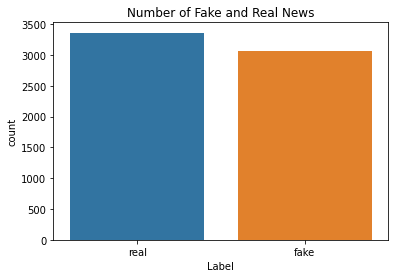

In [158]:
sns.countplot(fake_train.label)
plt.xlabel('Label')
plt.title('Number of Fake and Real News');

#Create the Input and Output Vectors

In [159]:
X = fake_train1.tweet
Y = fake_train1.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

#Split Train, Test Set

In [160]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

#Process the data

*   Tokenize the data and convert the text to sequences.
*   Add padding to ensure that all the sequences have the same shape
*  There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.






In [161]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

#Building the Model (Bi-Directional LSTM)

In [162]:
def BiDirect_LSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64, return_sequences=True)(layer)
    layer = LSTM(32)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

#Call the function and then compile the model

In [163]:
model = BiDirect_LSTM()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_7 (LSTM)               (None, 150, 64)           29440     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 FC1 (Dense)                 (None, 256)               8448      
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0   

# Fit the training data

In [164]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 15s 308ms/step - loss: 0.5550 - accuracy: 0.7592 - val_loss: 0.3734 - val_accuracy: 0.8233
Epoch 2/10
35/35 [==============================] - 10s 278ms/step - loss: 0.2760 - accuracy: 0.8923 - val_loss: 0.2490 - val_accuracy: 0.8938
Epoch 3/10
35/35 [==============================] - 10s 281ms/step - loss: 0.1954 - accuracy: 0.9260 - val_loss: 0.2271 - val_accuracy: 0.9084
Epoch 4/10
35/35 [==============================] - 10s 279ms/step - loss: 0.1620 - accuracy: 0.9377 - val_loss: 0.2309 - val_accuracy: 0.9038
Epoch 5/10
35/35 [==============================] - 10s 283ms/step - loss: 0.1250 - accuracy: 0.9526 - val_loss: 0.2638 - val_accuracy: 0.9002
Epoch 6/10
35/35 [==============================] - 10s 277ms/step - loss: 0.1092 - accuracy: 0.9595 - val_loss: 0.3048 - val_accuracy: 0.8965
Epoch 7/10
35/35 [==============================] - 10s 278ms/step - loss: 0.1016 - accuracy: 0.9645 - val_loss: 0.3148 - val_accuracy: 0.8947

#Process the test set data.

In [165]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

#Evaluate the model on the test set.

In [166]:
accr = model.evaluate(test_sequences_matrix,Y_test)

31/31 [==============================] - 1s 32ms/step - loss: 0.2936 - accuracy: 0.9107


In [167]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.294
  Accuracy: 0.911


(0.0, 0.5790072362869978)

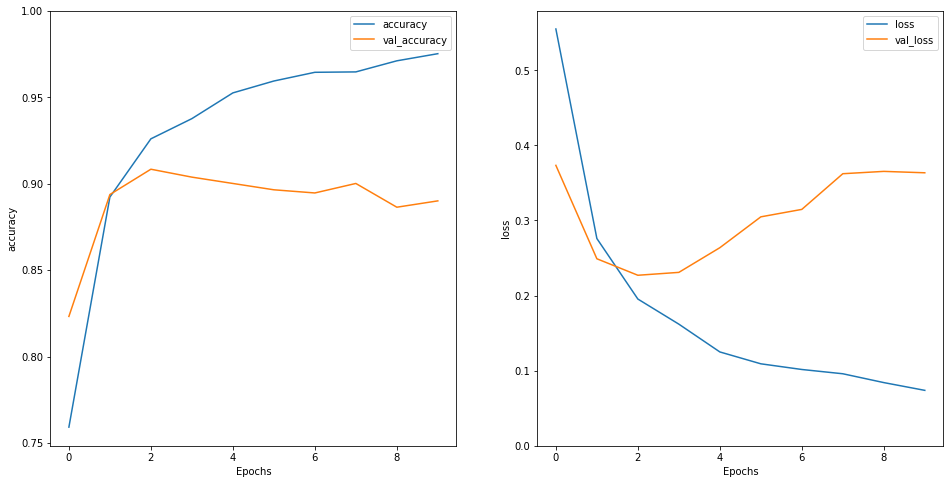

In [168]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)